# Simulations - 1 

In [36]:
library(repr)
options(repr.plot.width=7, repr.plot.height=6, repr.plot.res = 220, repr.plot.quality = 80)
options(jupyter.plot_mimetypes = 'image/png')

In [37]:
setwd("~/yandexDisk/DIPLOMA/CODE/src/")

In [38]:
source("./simulations.functions.R", echo=FALSE)

In [39]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <-  100
offsets = seq(0.1, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.simulations <- 3

In [40]:
# prepare train data
train.data.list <- GetSimulationData(sample.size, number.of.covariates)
train.covariates  = train.data.list$covariates
train.treatment   = train.data.list$treatment
train.raw.reward  = train.data.list$reward$raw.reward
train.reward      = train.raw.reward + train.data.list$reward$shift
train.prop.scores = train.data.list$prop.scores

# prepare test data
test.data.list <- GetSimulationData(test.data.sample.size, 
                                    number.of.covariates)
test.covariates  = test.data.list$covariates
test.treatment   = test.data.list$treatment
test.raw.reward  = test.data.list$reward$raw.reward
test.reward      = test.raw.reward + test.data.list$reward$shift
test.prop.scores = test.data.list$prop.scores

In [90]:
# Test DCA on nonshifted reward 
global.result <- list()
for (offset in  offsets) {
  print(paste("Optimization offset: ", offset))
  result <- foreach (lambda = lambdas) %dopar% {
    folds <- createFolds(train.treatment)
    # mean.dtr.value.gen.sa <- GetDtrValuesOnFolds(folds, train.treatment,
    #     train.covariates, train.prop.scores, train.reward, offset,
    #     control.offset, PolicyFunLinearKernel, lambda,
    #     list("obj.func"=ObjectiveFunction))
    dtr.values.on.folds.dca <- GetDtrValuesOnFolds(folds, train.treatment,
        train.covariates, train.prop.scores, train.reward, train.raw.reward,
        offset, control.offset, PolicyFunLinearKernel, lambda)
    opt.params.dca <- OptimizeParamsOfPolicyFunction(train.treatment,
        train.covariates, train.prop.scores, train.reward, offset,
        PolicyFunLinearKernel, lambda)
    dtr.value.on.test.dca <- ValueFunction(opt.params.dca, test.treatment,
        test.covariates,  test.prop.scores,  test.raw.reward,
        offset, PolicyFunLinearKernel)
    return (list("offset"=offset, "lambda"=lambda,
                 # "value.function.gen.sa"=mean.dtr.value.gen.sa,
                 "dtr.values.on.folds.dca"=dtr.values.on.folds.dca,
                 "dtr.value.on.test.dca"=dtr.value.on.test.dca))
  }
  global.result <- c(global.result, result)
}

# create result matrix with statistics for every params combination tested
global.result.df <- as.data.frame(t(sapply(global.result, cbind)))
colnames(global.result.df)  <- names(global.result[[1]])

[1] "Optimization offset:  0.1"
[1] "Optimization offset:  0.2"
[1] "Optimization offset:  0.3"
[1] "Optimization offset:  0.4"
[1] "Optimization offset:  0.5"
[1] "Optimization offset:  0.6"
[1] "Optimization offset:  0.7"
[1] "Optimization offset:  0.8"
[1] "Optimization offset:  0.9"
[1] "Optimization offset:  1"


Выбранные по кроссвалидации параметры:

In [91]:
result.to.plot <- global.result.df[, names(global.result.df) %in%
                                     c("offset", "lambda",
                                       "value.function.gen.sa",
                                       "dtr.values.on.folds.dca",
                                       "dtr.value.on.test.dca")]

result.to.plot$sd <- sapply(result.to.plot$dtr.values.on.folds.dca, sd)
result.to.plot$mean.folds.dtr.value.dca <- sapply(
   result.to.plot$dtr.values.on.folds.dca, mean)
# result.to.plot <- as.data.frame(result.to.plot)
result.to.plot <- as.data.frame(lapply(result.to.plot, function(x) as.numeric(unlist(x))))
result.to.plot$lambda  <- as.factor(result.to.plot$lambda)

pars.dca <-  result.to.plot[ which.max(result.to.plot$mean.folds.dtr.value.dca),  ]
best.offset.dca <- pars.dca$offset
best.lambda.dca <- pars.dca$lambda
cat("Choosen params by CV:")
pars.dca

Choosen params by CV:

offset           lambda dtr.values.on.folds.dca dtr.value.on.test.dca
20    0.2 6.36363636363636               0.3449904             0.5640023
         sd mean.folds.dtr.value.dca
20 40.02463                 14.57006

In [93]:
opt.params.dca <- OptimizeParamsOfPolicyFunction(train.treatment,
    train.covariates, train.prop.scores, train.reward, best.offset.dca,
    PolicyFunLinearKernel, best.lambda.dca)


dtr.value.on.test.dca <- ValueFunction(opt.params.dca, test.treatment,
    test.covariates,  test.prop.scores,  test.raw.reward,
    best.offset.dca, PolicyFunLinearKernel)
cat("CV choosen DTR value using all train: ", dtr.value.on.test.dca)

Iteration 0 
Iteration 1 
CV choosen DTR value using all train:  1.443986

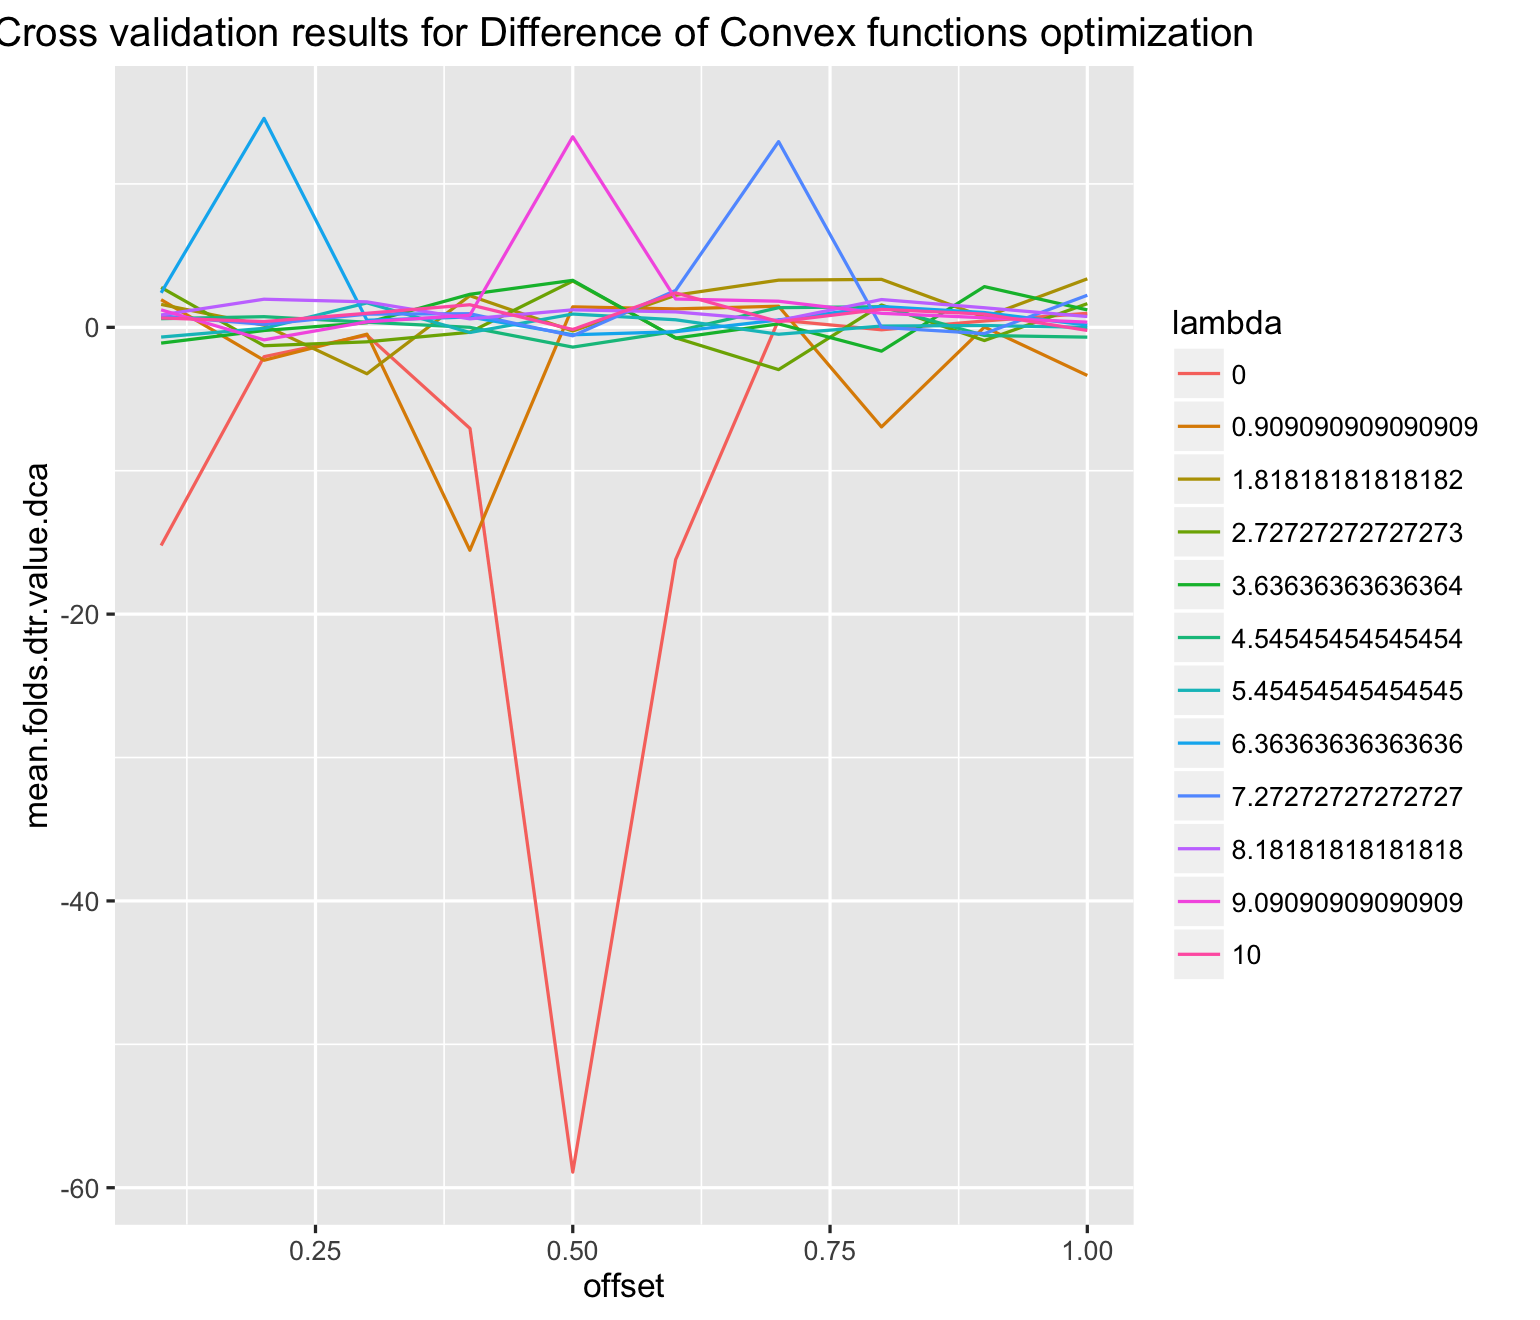

In [95]:
ggplot(result.to.plot, aes(x = offset, y = mean.folds.dtr.value.dca, colour = lambda)) +
#   geom_errorbar(aes(ymin=value.function.dca-sd, 
#                       ymax=value.function.dca+sd), width=0.01) +
  geom_line() +
  ggtitle("Cross validation results for Difference of Convex functions optimization")

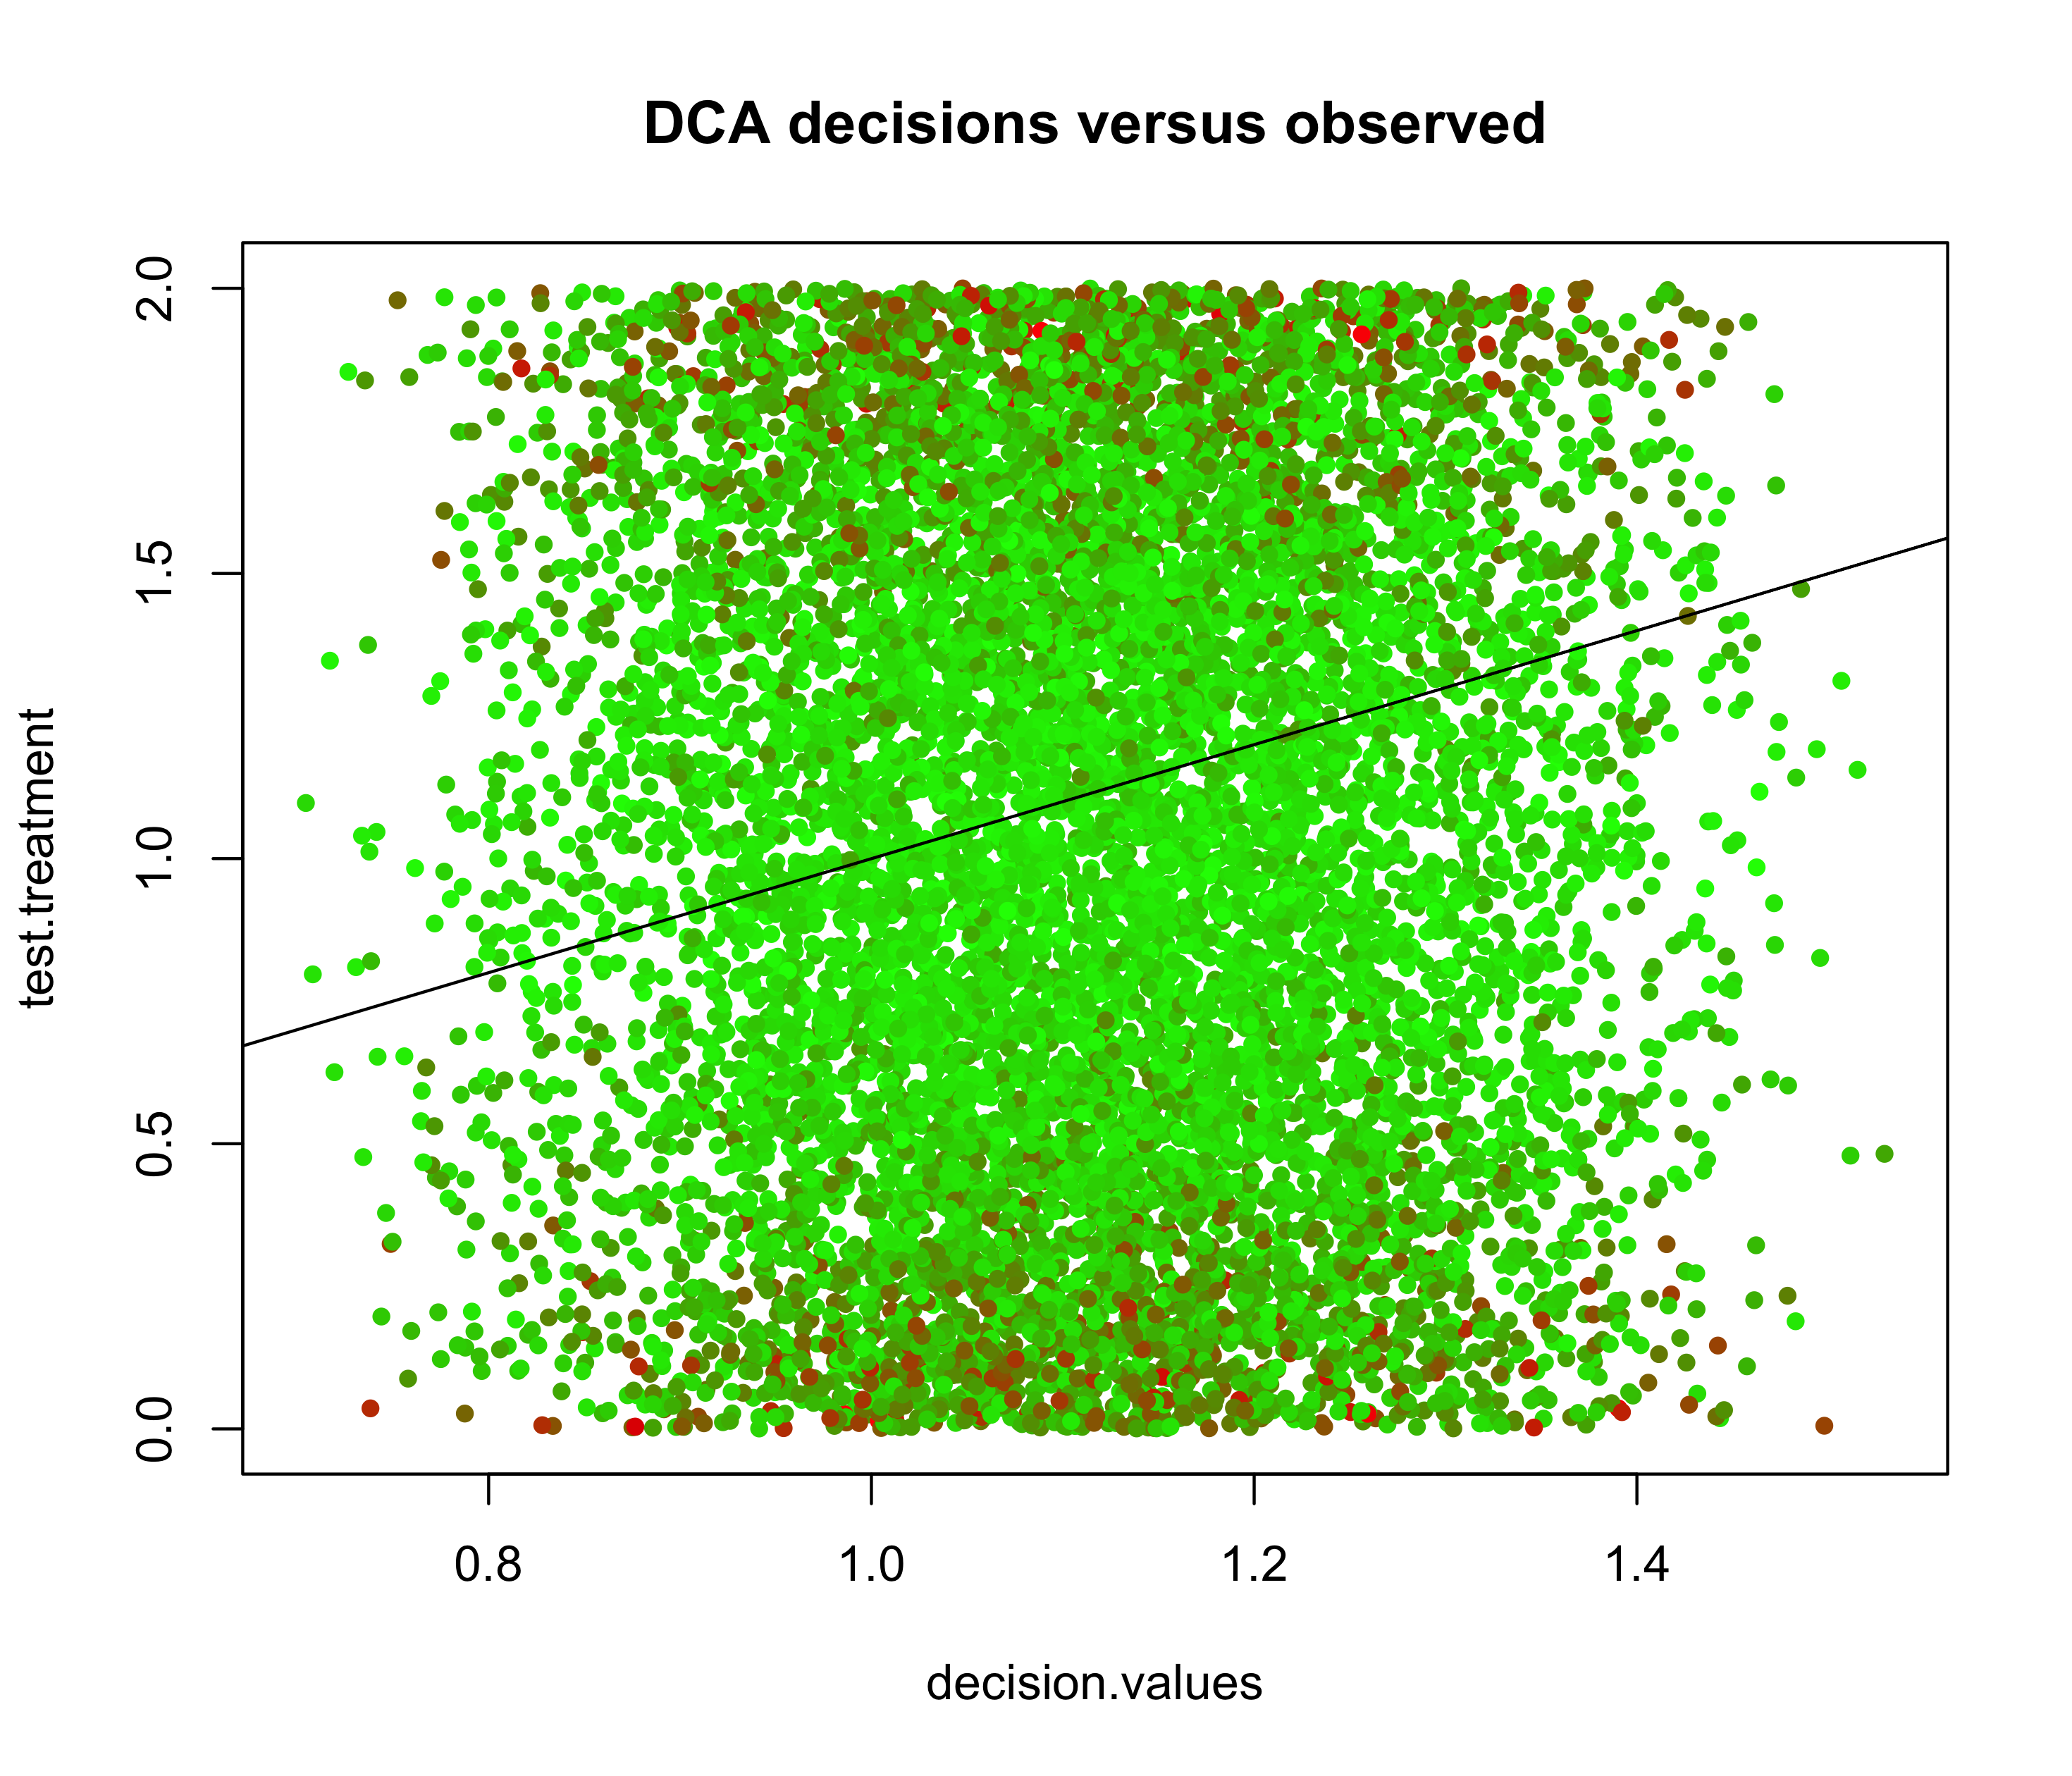

In [31]:
# Plot decisions versus observed treatment 
decision.values <- PolicyFunLinearKernel(opt.params.dca, test.covariates)
rewards.scaled.0.1 <- (test.reward - min(test.reward) ) /
                      (max(test.reward) - min(test.reward))
plot(decision.values, test.treatment,
     col=rgb(1 - rewards.scaled.0.1, rewards.scaled.0.1, 0),
     pch=20, main="DCA decisions versus observed")
abline(0, 1)

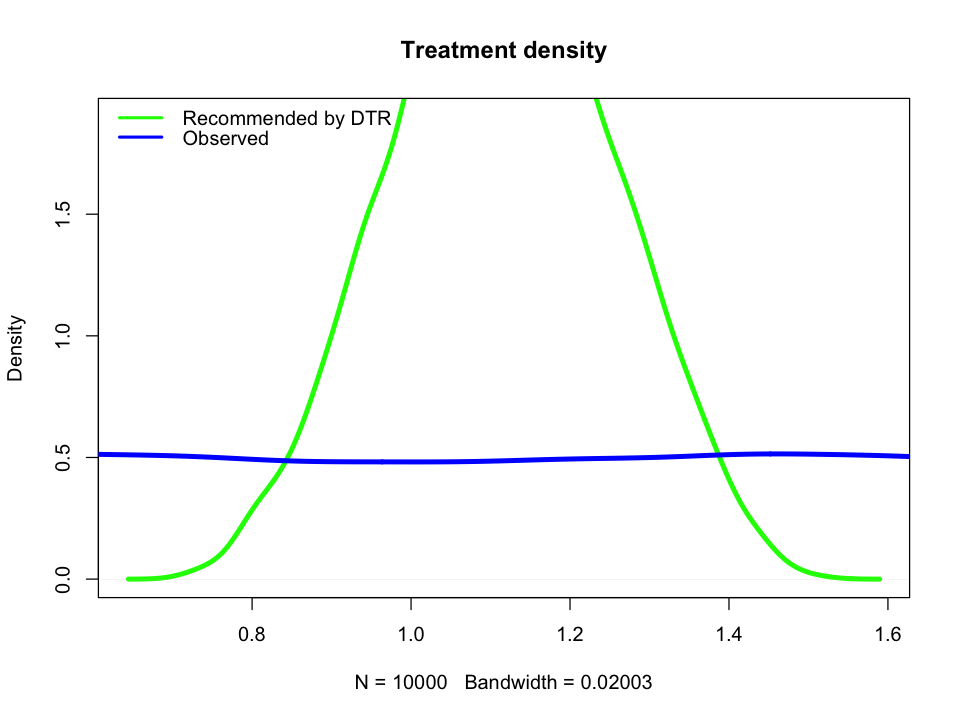

In [26]:
plot(density(decision.values), col="green", lwd=4,  ylim=c(0, 1.9),
     main = "Treatment density")
lines(density(test.treatment), col="blue", lwd=4)
legend("topleft", c("Recommended by DTR", "Observed"),
       lwd=c(2.5,2.5),col=c("green","blue"), bty = "n")

In [24]:
# get best possible combinations of lambda and offset based on test performance
best.index <-  which.max(result.to.plot$dtr.values.on.test.dca)
cat("Best possible result:")
result.to.plot[best.index, ]

best.lambda.on.test <- result.to.plot[best.index, "lambda"]
best.offset.on.test <- result.to.plot[best.index, "offset"]

Best possible result:

offset lambda value.function.dca dtr.values.on.test.dca       sd
36    0.3     10           1.255724               1.427128 3.970947

Iteration 0 
Iteration 1 


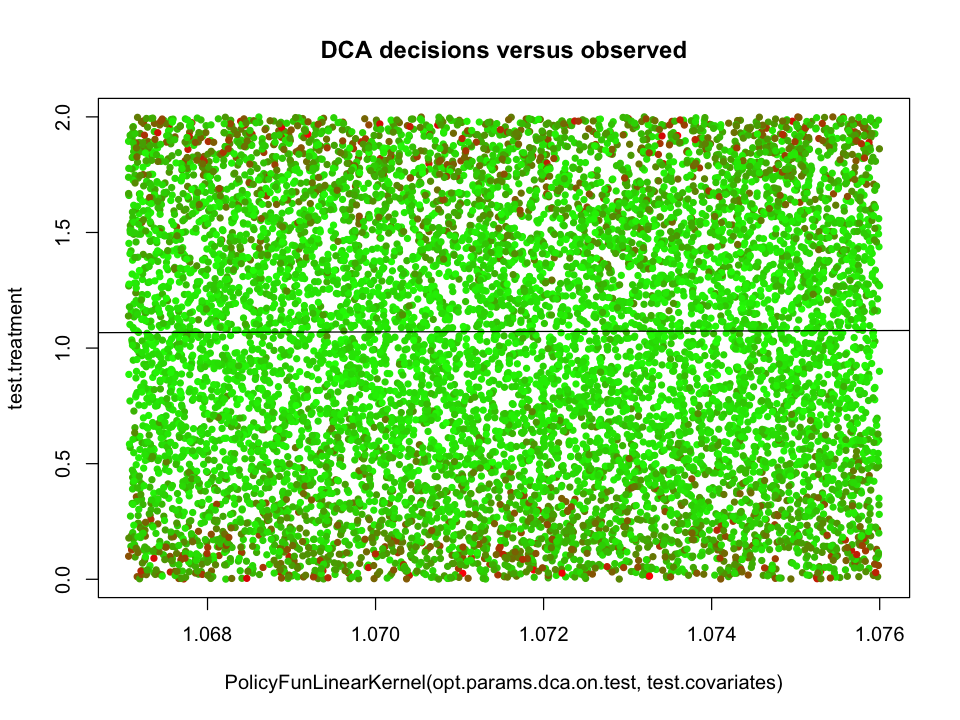

In [25]:
# Plot best decision possible (on test data)
opt.params.dca.on.test <- OptimizeParamsOfPolicyFunction(train.treatment,
    train.covariates, train.prop.scores, train.reward, best.offset.on.test,
    PolicyFunLinearKernel, best.lambda.on.test)

rewards.scaled.0.1 <- (test.reward - min(test.reward) ) /
                      (max(test.reward) - min(test.reward))
plot(PolicyFunLinearKernel(opt.params.dca.on.test, test.covariates),
     test.treatment,
     col=rgb(1 - rewards.scaled.0.1, rewards.scaled.0.1, 0),
     pch=20, main="DCA decisions versus observed")
abline(0, 1)

# Проблемы

1. Почему обращается value function в 0 на тестовой выборке с ростом параметра сдвига ?

    > Потому что мы оцениваем сравниваем между собой ценности DTR на заданном фиксированном и малом отступе $\varphi = 0.005$ Ноль получается потому что в радиус этого отступа относительно наблюденного treatment не попадет наш предсказанный treatment ни для какого из предсказаний. Все, что показано ниже сделано для увеличенного в 10 раз $\varphi = 0.005 \to \varphi = 0.05$ 

2. Попробовать сдвигать обратно reward перед вычислением value function ?
    > Попробовал оптимизировать только по сдвинутым значениям value function, а оценивать в процессе CV  с помощью сырых reward. Результат интересный. В двух словах, идеальный value function на тестовых данных держится в районе 1.5, что ближе, чем полученное ранее $\sim 40$. Правда я еще прикрутил дополнительно CBPS в two step mode.    

3. Попробовать квадрат / логарифм / : неотрицательность дозы
     > Учитывая, что в отрицательную область предсказания перестали уходить, это не делал

4. Попробовать lambda=0

    > При кросс валидации видно, что это далеко не лучший способ, дает хуже результаты, чем при каком-нибудь другом $\lambda$. 

5. Попробовать быструю оптимизацию которая умеет много параметров вместо annealing

    > ** Пока не успел **

6. Написать деревьям, если не ответят - на mail list R help 

    > Написал деревьям, код MIDAs у нас есть. Они его не выложили еще в публичный доступ, потому что в процессе допиливания кода на fortran, который под капотом у этого MIDAs

7. Почему при $\lambda \to \infty$ мы получаем наилучшее value func  в  симуляции?

    > Причинной этому является то, что у нас очень интересно расположены точки в симуляции. При крайних значениях treatment (вблизи 0 и вблизи 2.0) мы имеем большинство плохих резульататов. Поэтому  linear DTR  стремится стать вообще горизонтальной линией $y=1$. 

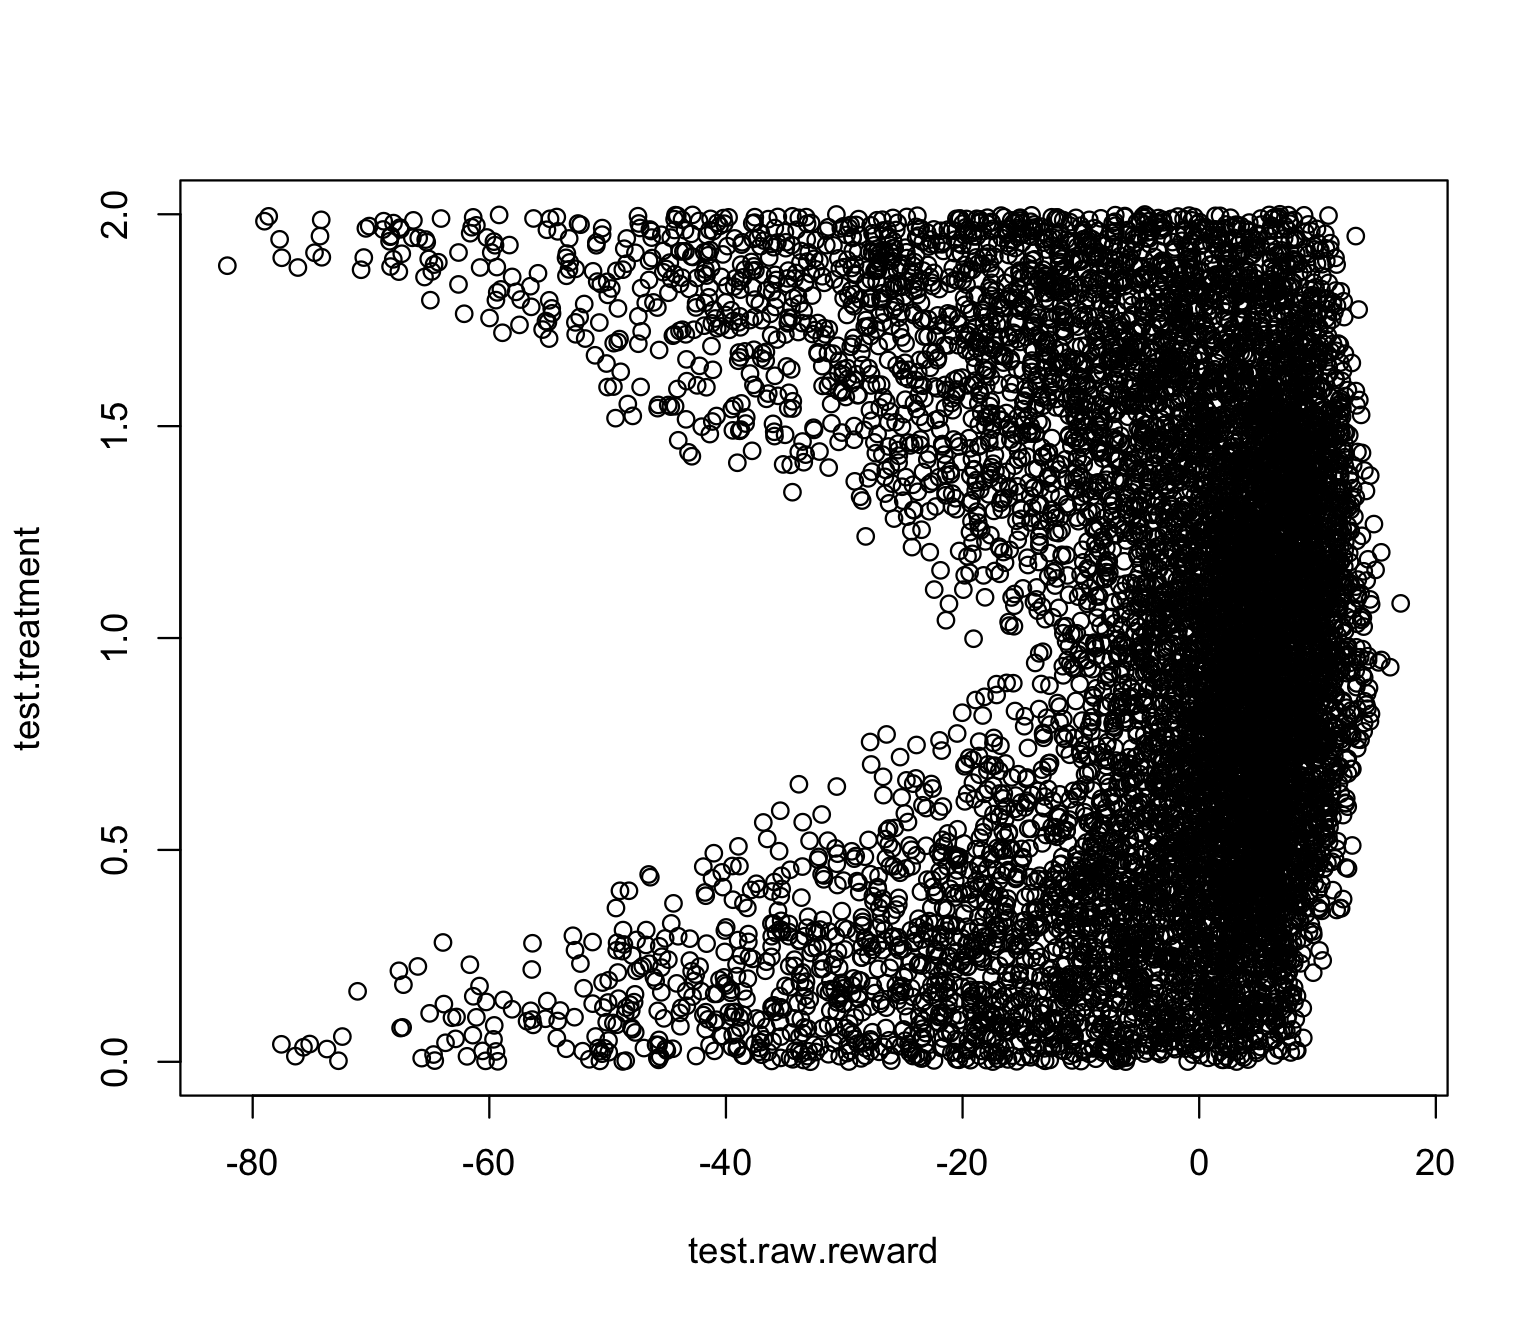

In [97]:
plot(test.raw.reward, test.treatment)